In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import scipy.fft
import matplotlib.pylab as plt

from pyinverse.axis import RegularAxis, FFTRegularAxis, RFFTRegularAxis, RegularGrid, dtft2
from pyinverse.util import besinc

## 1-D

From e.g., Blahut we have $\text{rect}(t) \leftrightarrow \text{sinc}(f)$. These functions are defined as
\begin{equation}
\text{rect}(t) =
\begin{cases}
1 & |t| \leq \frac12 \\
0 & \text{otherwise}
\end{cases}
\end{equation}
and
\begin{equation}
\text{sinc}(x) = \frac{\sin\pi x}{\pi x}
\end{equation}
where $\text{sinc}(0) = 1$.

From, e.g., Oppenheim and Schaffer, we have that the DFT of the discrete rect window function of length $L$ is
\begin{equation}
W_r(e^{j\omega}) = \sum_{n=0}^{L-1} e^{-j\omega n} = e^{-j\omega(L-1)/2} \frac{\sin(\omega L/2)}{\sin(\omega /2)}
\end{equation}
Note that $W_r(0) = L$.

The discrete rect window function is defined as
\begin{equation}
w_r(n) = 
\begin{cases}
1 & 0 \leq n < L \\
0 & \text{otherwise}
\end{cases}
\end{equation}

In [3]:
Ts = 0.01
N = 501 # chosen to force zero padding (as determined by scipy.fft.next_fast_len)
d = 1/(Ts*N)
t_axis = FFTRegularAxis(N, d=d).increasing()

In [4]:
def rect(t):
    y = np.zeros_like(t)
    y[np.abs(t) <= 0.5] = 1
    return y

In [5]:
y = rect(t_axis)

In [6]:
L = np.count_nonzero(y)
shift = np.argwhere(y > 0)[0][0]

In [7]:
def w_r(n, L):
    y = np.zeros_like(n)
    y[(0 <= n) & (n < L)] = 1
    return y

In [8]:
def W_r(omega, L):
    y = np.empty_like(omega, dtype=np.complex)
    y[omega == 0] = L
    I = omega != 0
    y[I] = np.exp(-1j*omega[I]*(L-1)/2) * np.sin(omega[I]*L/2) / np.sin(omega[I]/2)
    return y

<IPython.core.display.Javascript object>


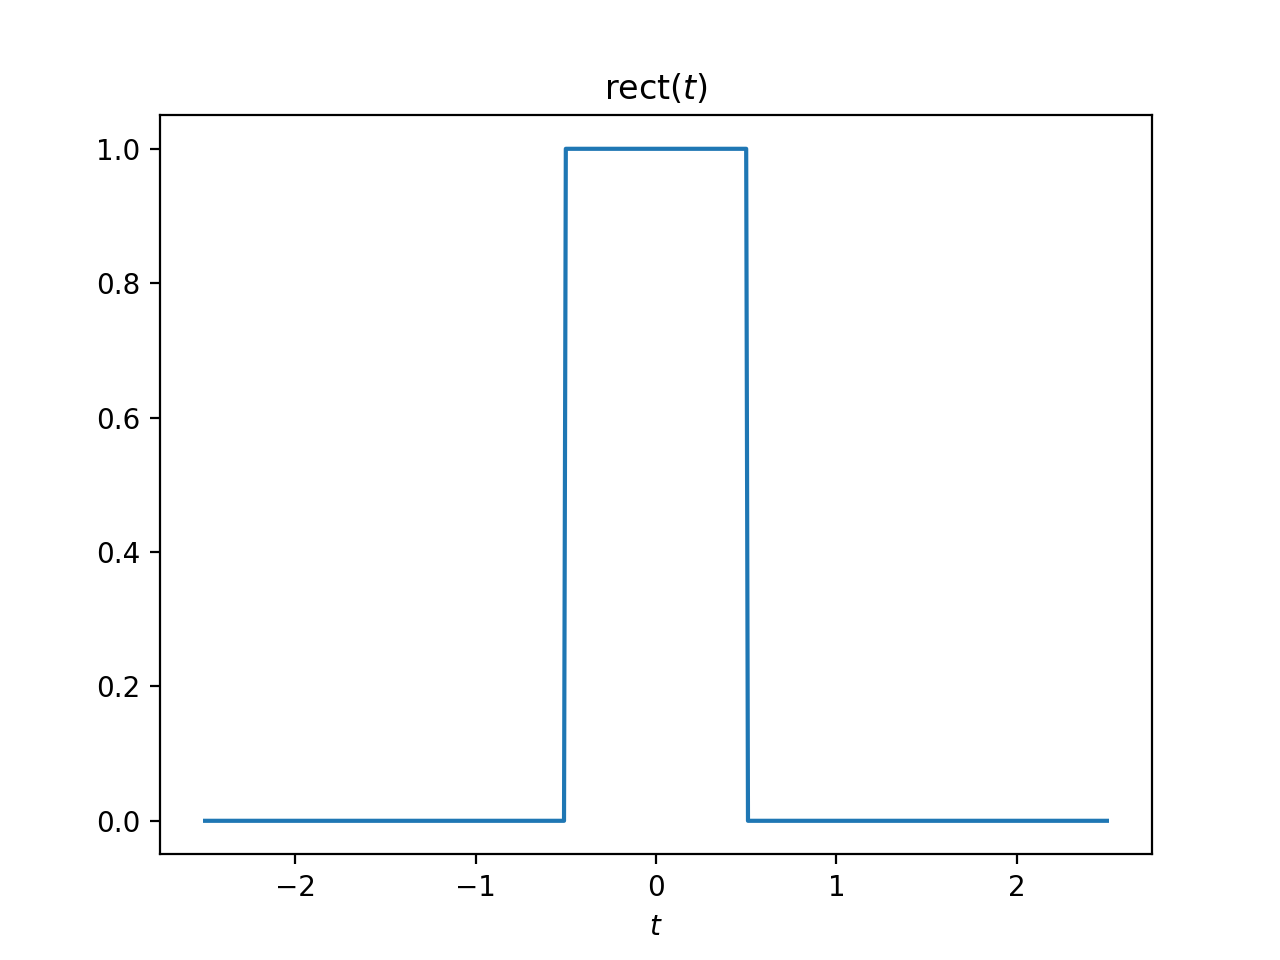

In [9]:
fig, ax = plt.subplots()
ax.plot(t_axis, y)
ax.set_xlabel(r'$t$')
ax.set_title(r'rect$(t)$');

In [10]:
axis_Omega, y_Omega = t_axis.spectrum(y)

In [11]:
Fs = 1/Ts
Fn = Fs/2
f = np.linspace(-Fn, Fn, N*8)
Omega = 2*np.pi*f

In [12]:
Yc_theory = np.sinc(f)

<IPython.core.display.Javascript object>


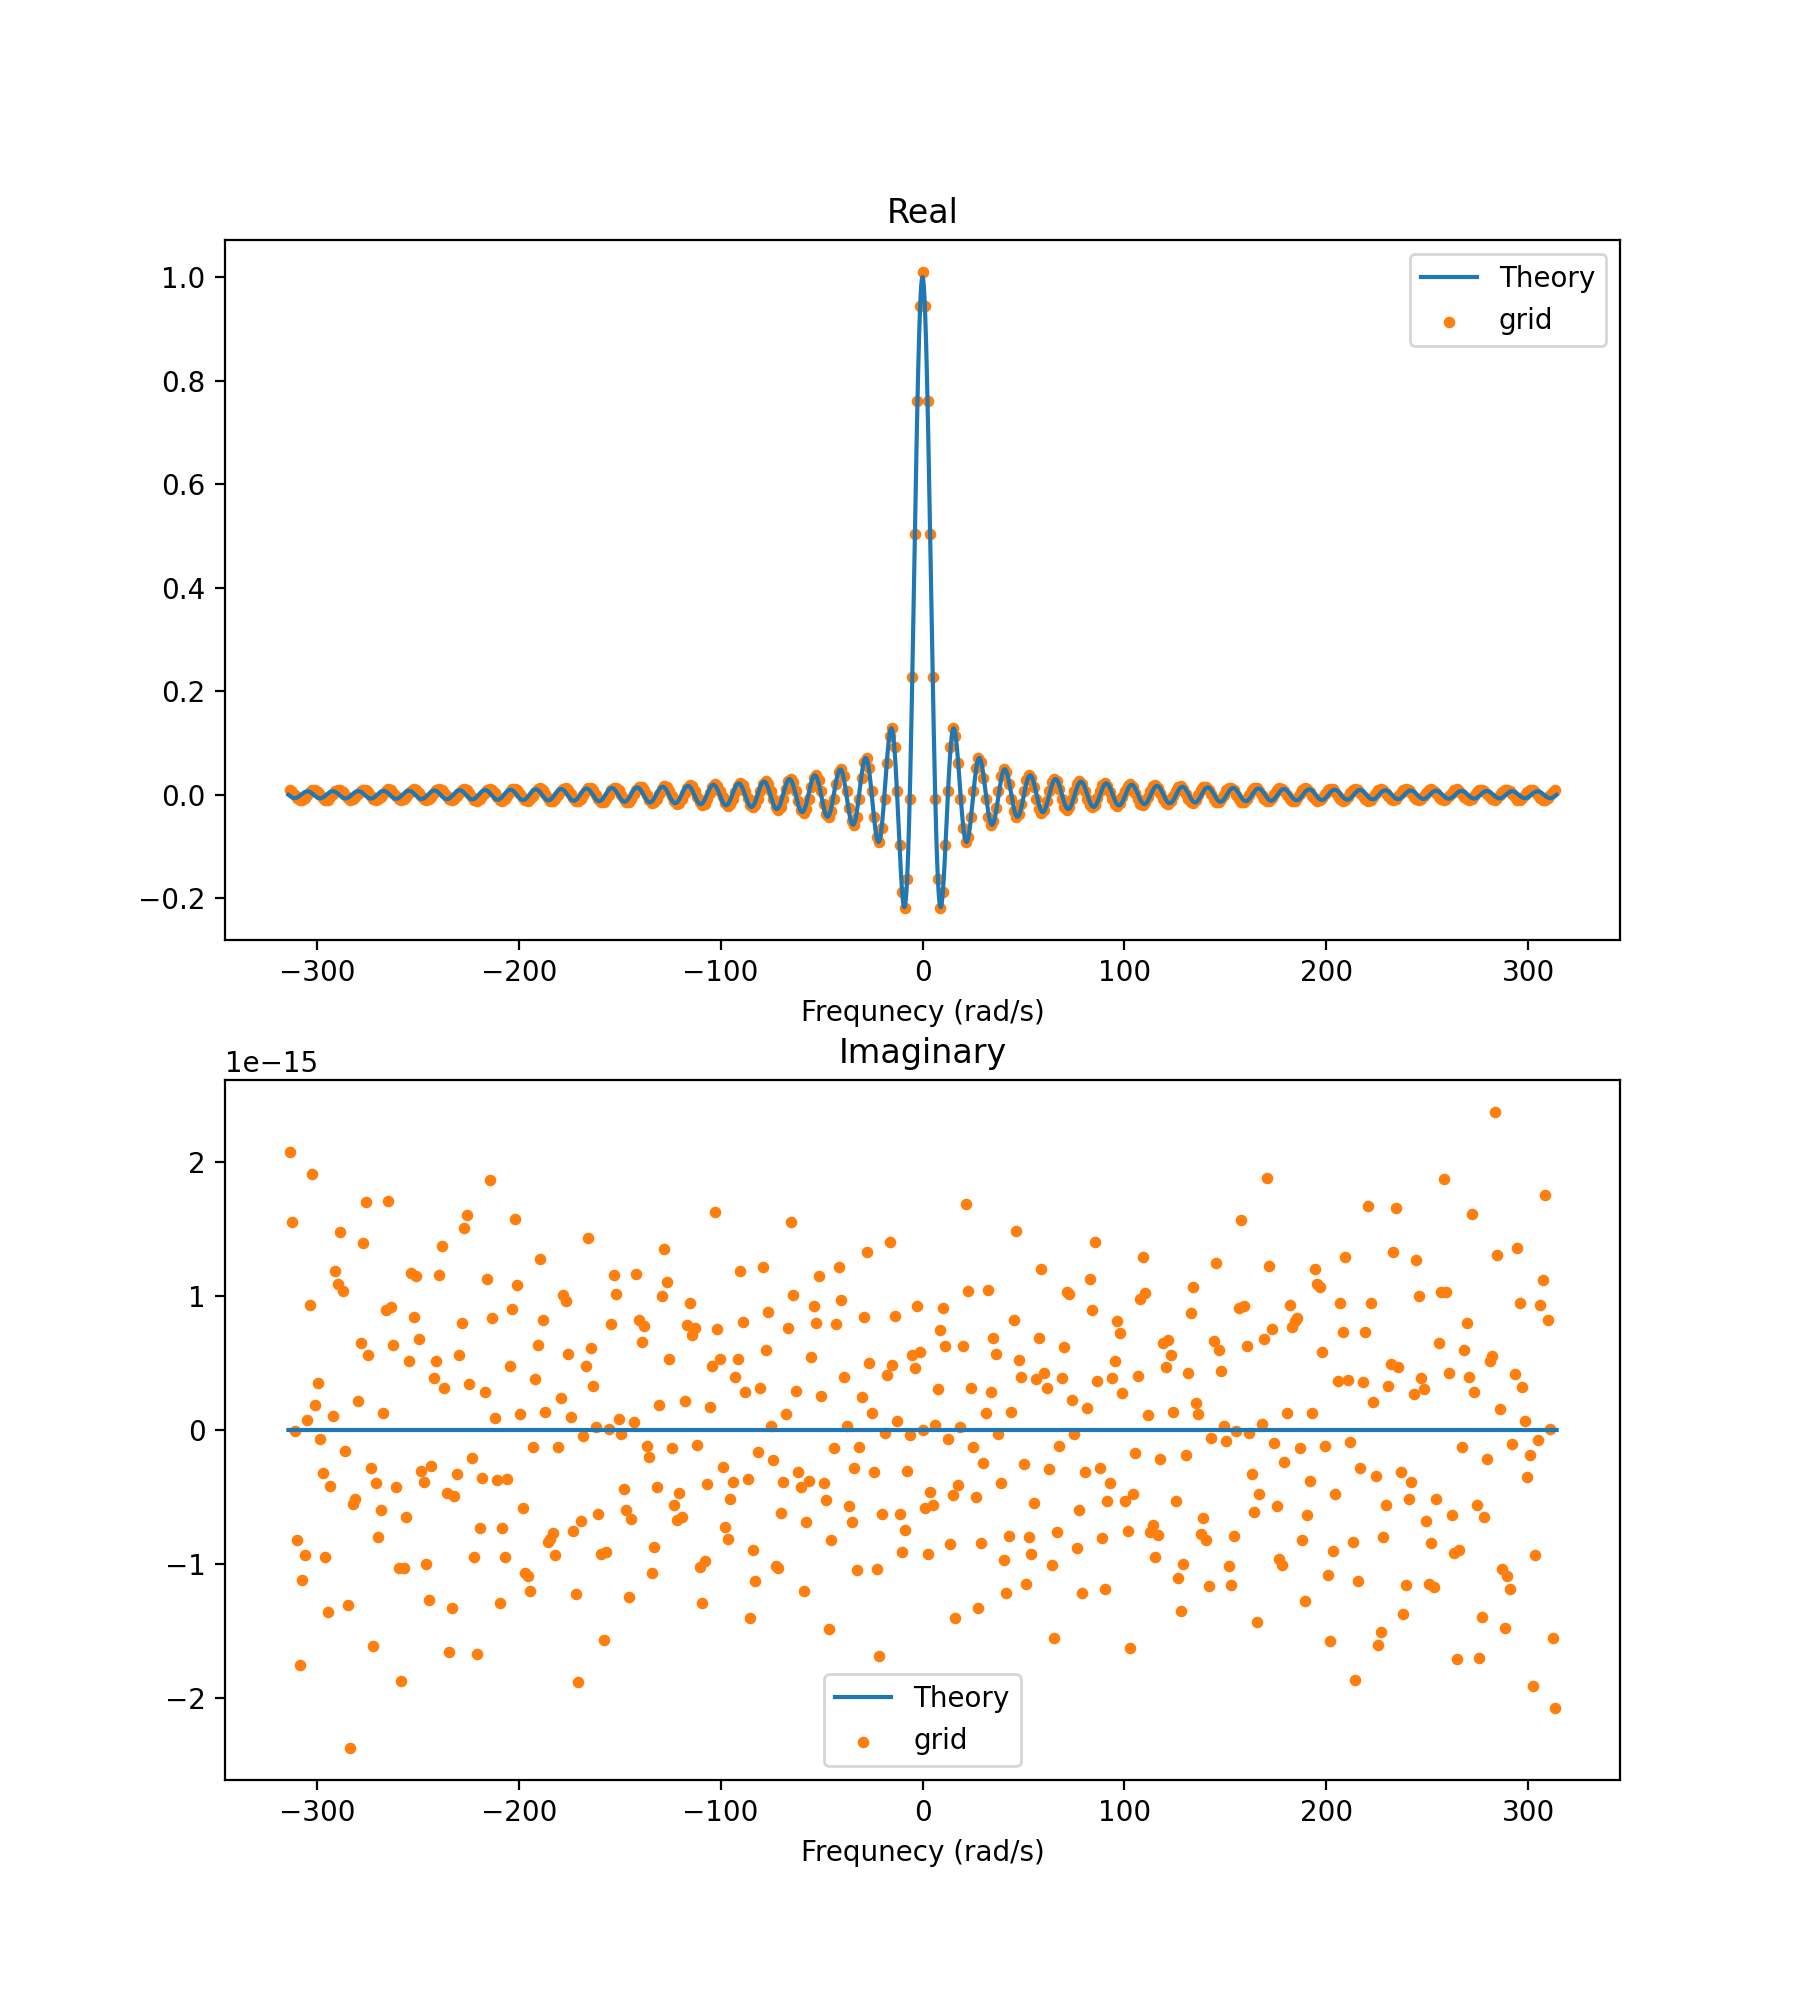

In [13]:
fig, ax = plt.subplots(nrows=2, figsize=(9, 10))
ax[0].plot(Omega, np.real(Yc_theory), label='Theory')
ax[0].scatter(axis_Omega.centers, np.real(y_Omega), c='C1', s=10, label='grid')
ax[0].legend()
ax[0].set_xlabel('Frequnecy (rad/s)')
ax[0].set_title('Real')
ax[1].plot(Omega, np.imag(Yc_theory), label='Theory')
ax[1].scatter(axis_Omega.centers, np.imag(y_Omega), c='C1', s=10, label='grid')
ax[1].legend()
ax[1].set_xlabel('Frequnecy (rad/s)')
ax[1].set_title('Imaginary');

In [14]:
#t_axis_ipectrum, y_ispectrum = axis_Omega.ispectrum(np.sinc(axis_Omega.centers/(2*np.pi)))
t_axis_ipectrum, y_ispectrum = axis_Omega.ispectrum(y_Omega)

<IPython.core.display.Javascript object>


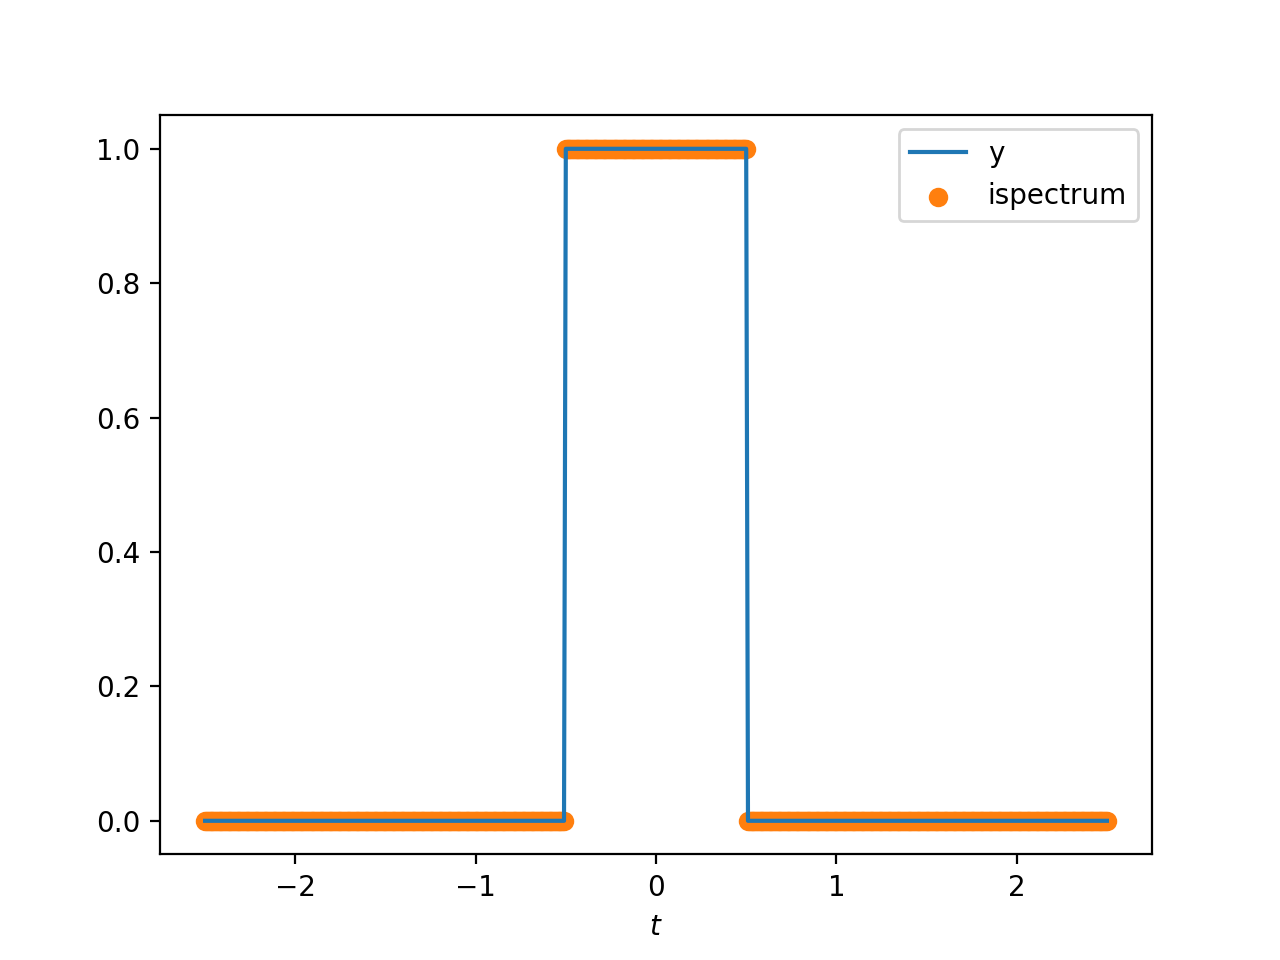

In [15]:
fig, ax = plt.subplots()
ax.plot(t_axis, y, label='y')
ax.scatter(t_axis, y_ispectrum, c='C1', label='ispectrum')
ax.set_xlabel(r'$t$')
ax.legend();

In [16]:
axis_Omega_real, y_Omega_real = t_axis.spectrum(y, real=True)

<IPython.core.display.Javascript object>


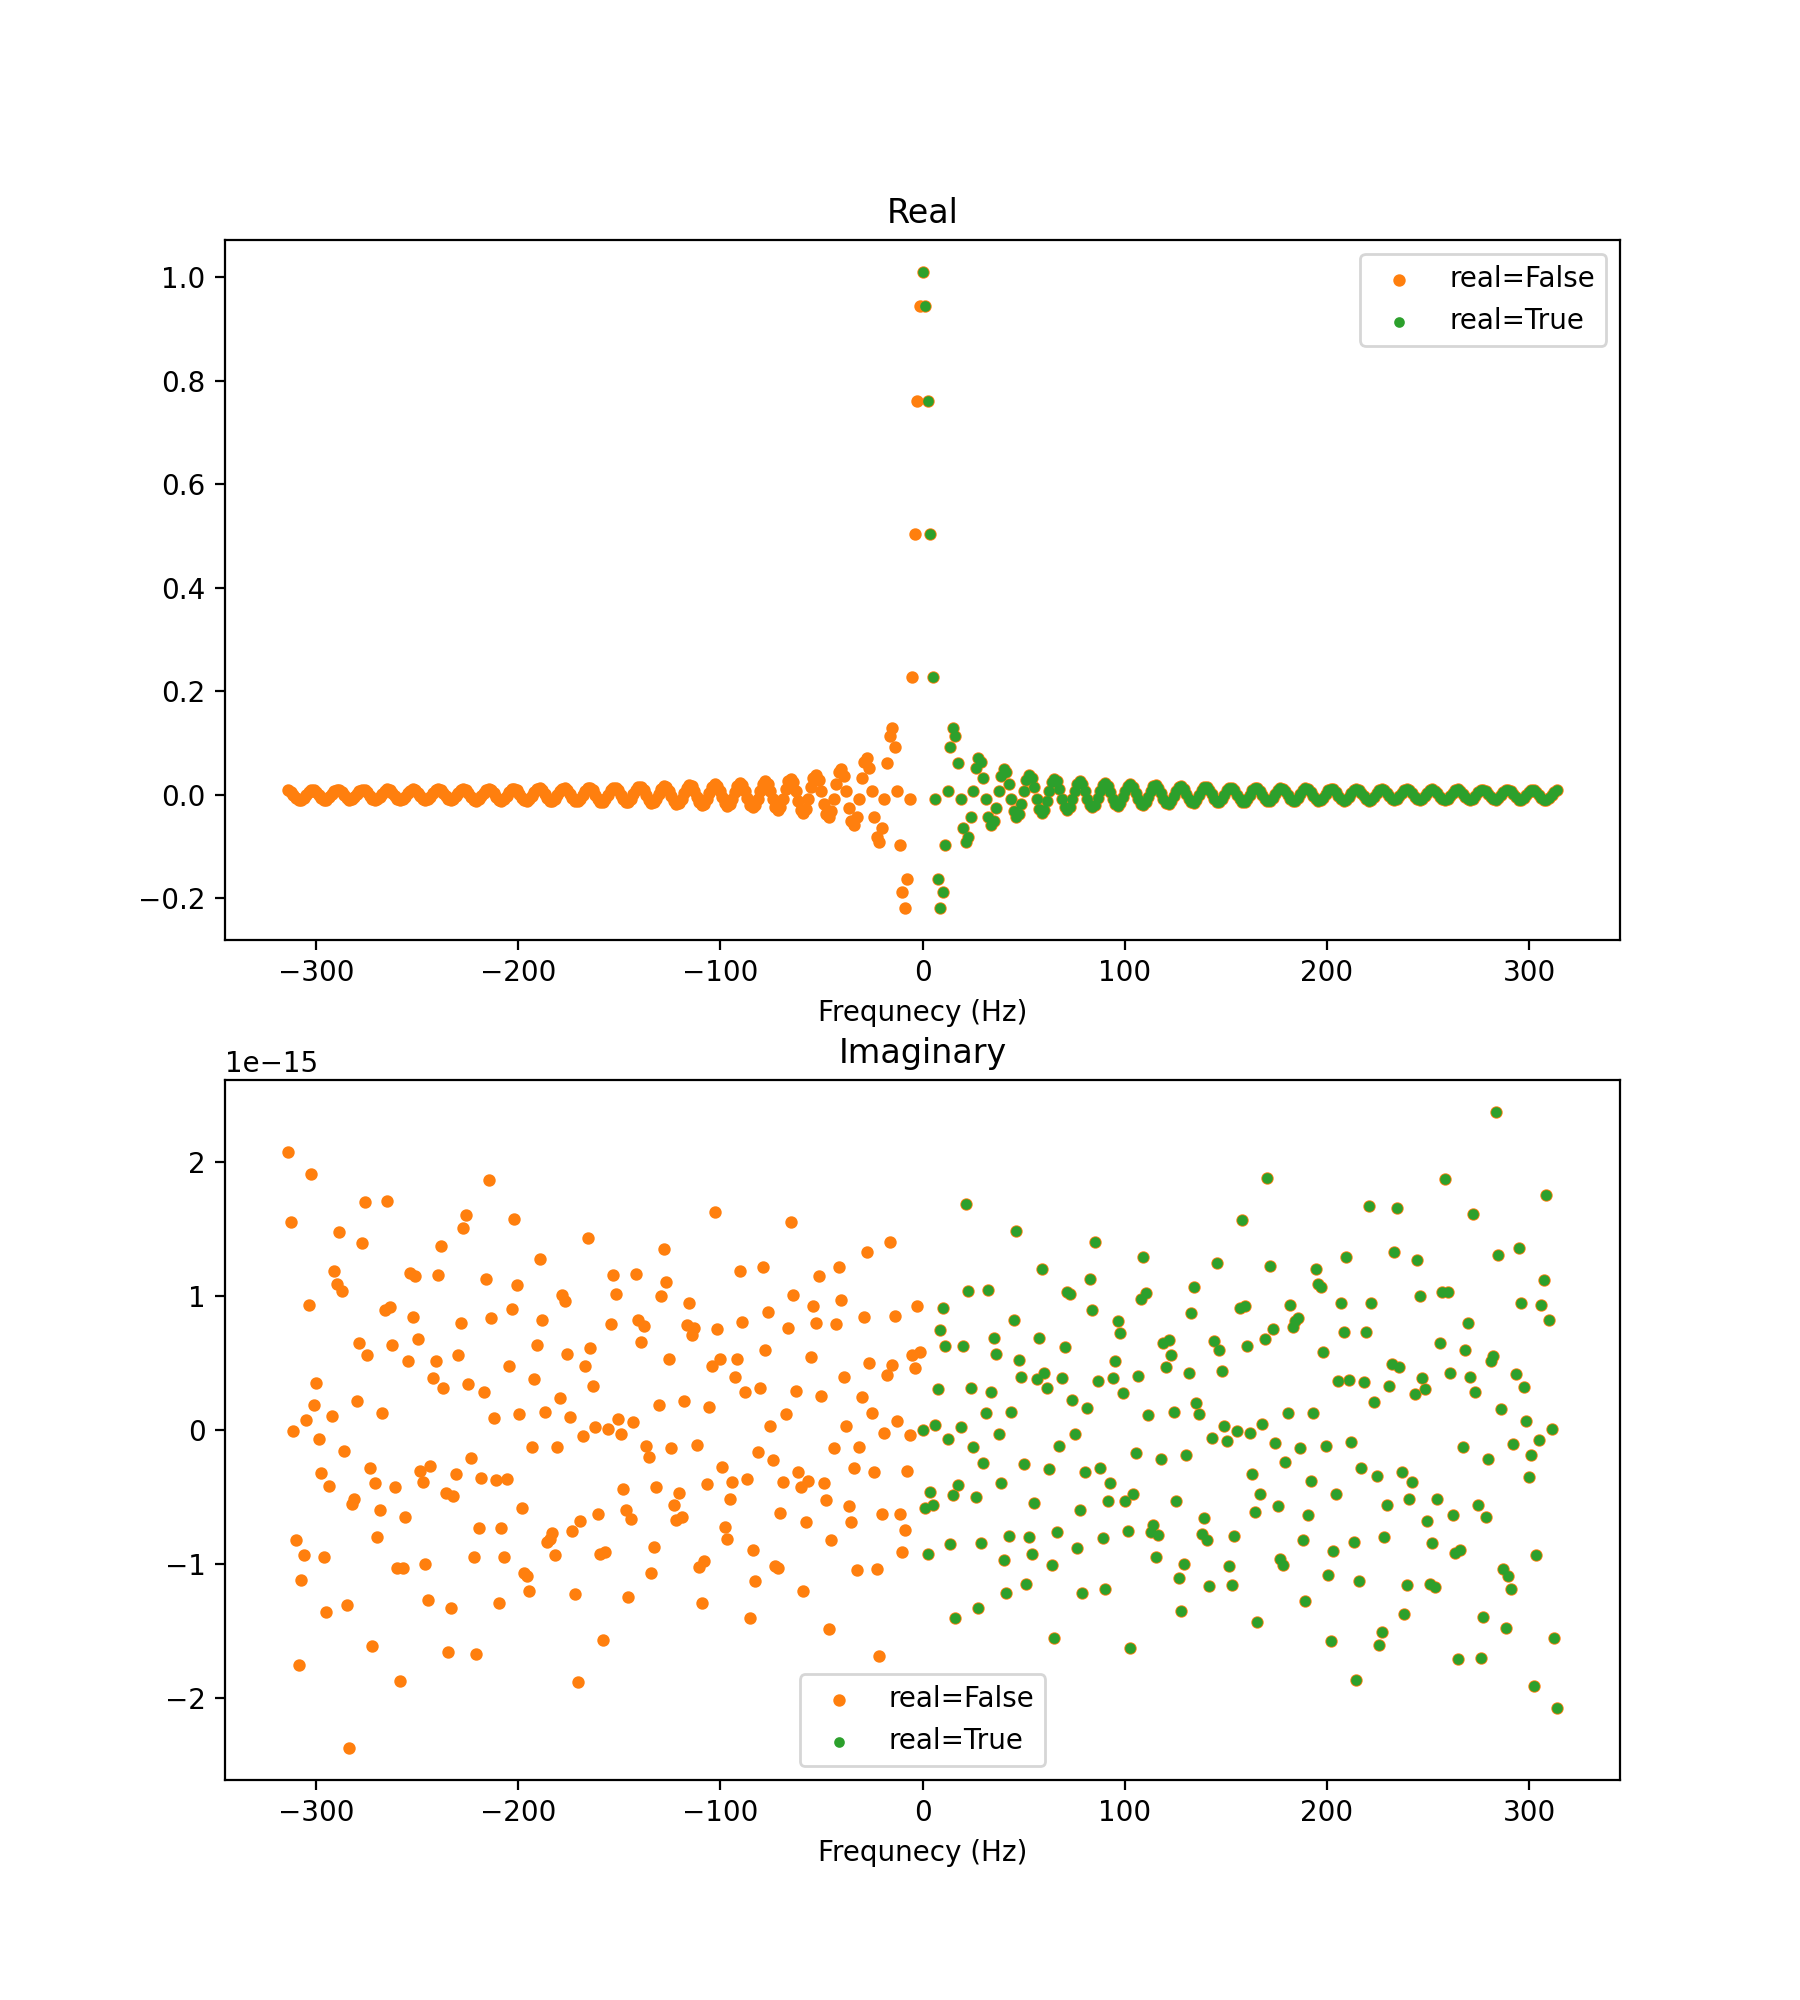

In [17]:
fig, ax = plt.subplots(nrows=2, figsize=(9, 10))
ax[0].scatter(axis_Omega.centers, np.real(y_Omega), s=12, c='C1', label='real=False')
ax[0].scatter(axis_Omega_real.centers, np.real(y_Omega_real), s=8, c='C2', label='real=True')
ax[0].legend()
ax[0].set_xlabel('Frequnecy (Hz)')
ax[0].set_title('Real')
ax[1].scatter(axis_Omega.centers, np.imag(y_Omega), s=12, c='C1', label='real=False')
ax[1].scatter(axis_Omega_real.centers, np.imag(y_Omega_real), s=8, c='C2', label='real=True')
ax[1].legend()
ax[1].set_xlabel('Frequnecy (Hz)')
ax[1].set_title('Imaginary');

In [18]:
t_axis_ispectrum_real, y_ispectrum_real = axis_Omega_real.ispectrum(y_Omega_real)

In [19]:
t_axis_ispectrum_real

RegularAxis(x0=-2.5, T=0.010000000000000002, N=501)

In [20]:
t_axis

RegularAxis(x0=-2.5, T=0.01, N=501)

<IPython.core.display.Javascript object>


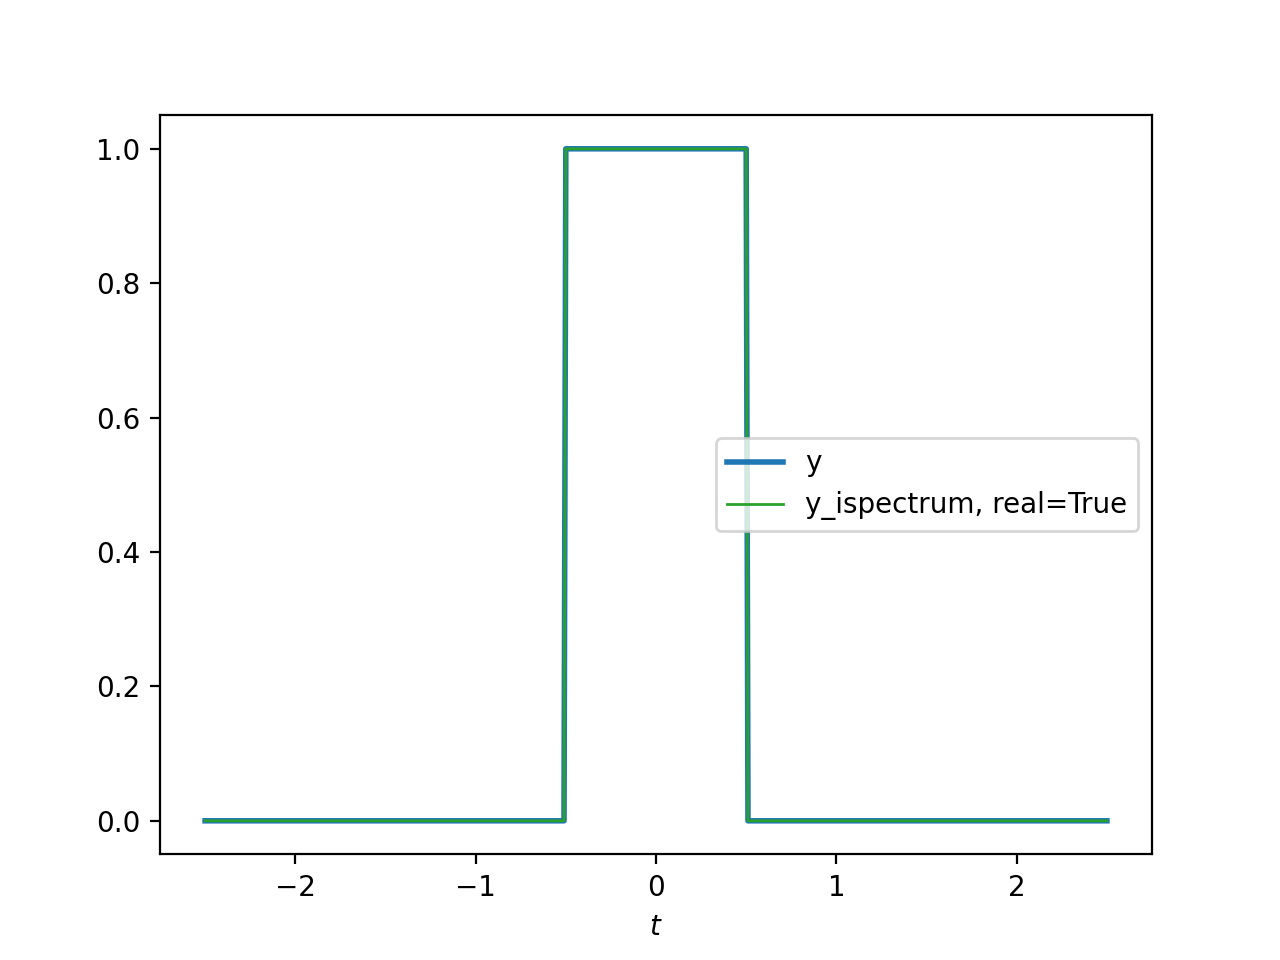

In [21]:
fig, ax = plt.subplots()
ax.plot(t_axis.centers, y, c='C0', lw=2, label='y')
ax.plot(t_axis_ispectrum_real.centers, y_ispectrum_real, c='C2', lw=1, label='y_ispectrum, real=True')
ax.legend()
ax.set_xlabel(r'$t$');

## 2-D

From Blahut we have $\text{circ}(x, y) \leftrightarrow \text{jinc}(f_x, f_y)$ where

\begin{equation}
\text{circ}(x, y) = \text{rect}\bigl(\sqrt{x^2 + y^2}\bigr)
\begin{cases}
1 & \sqrt{x^2 + y^2} \leq \frac12 \\
0 & \text{otherwise}
\end{cases}
\end{equation}

and $\text{jinc}(f_x, f_y) = \text{jinc}(\sqrt{f_x^2 + f_y^2})$ where

\begin{equation}
\text{jinc}(t) = \frac{J_1(\pi t)}{2t}
\end{equation}

and $J_1(x)$ is a the first-order Bessel function of the first kind and $\text{jinc}(0) = \frac{\pi}{4}$.

In [22]:
Ts_x = 0.01
#N_x = 501 # chosen to force zero padding (as determined by scipy.fft.next_fast_len) to 504 (even)
#N_x = 513 # chosen to force zero padding (as determined by scipy.fft.next_fast_len) to 525 (odd)
N_x = 501
d_x = 1/(Ts_x*N_x)
#x_axis = FFTRegularAxis(N_x, d=d_x)
#N_x = 501
# CHANGE TO axis_x
x_axis = RegularAxis.linspace(-N_x/2*Ts_x, N_x/2*Ts_x, N_x)

In [23]:
min(x_axis), max(x_axis)

(-2.505, 2.505)

In [24]:
Ts_y = 0.01
#N_y = 501 # chosen to force zero padding (as determined by scipy.fft.next_fast_len)
#N_y = 513
Ts_y = 0.05
N_y = 99
d_y = 1/(Ts_y*N_y)
#y_axis = FFTRegularAxis(N_y, d=d_y) 
# CHANGE to axis_y
y_axis = RegularAxis.linspace(-N_y/2*Ts_y, N_y/2*Ts_y, N_y)

In [25]:
grid = RegularGrid(x_axis, y_axis).increasing()

In [26]:
grid.shape, grid.centers[0].shape, grid.centers[1].shape

((99, 501), (99, 501), (99, 501))

In [27]:
circ = lambda x, y: rect(np.sqrt(x**2 + y**2))   # too slow
circ_vec = np.vectorize(circ, otypes=[np.float])

In [28]:
D = np.sqrt(grid.centers[0]**2 + grid.centers[1]**2)
y = np.zeros_like(D)
y[D <= 1/2] = 1

In [29]:
grid.shape

(99, 501)

In [30]:
y.shape

(99, 501)

<IPython.core.display.Javascript object>


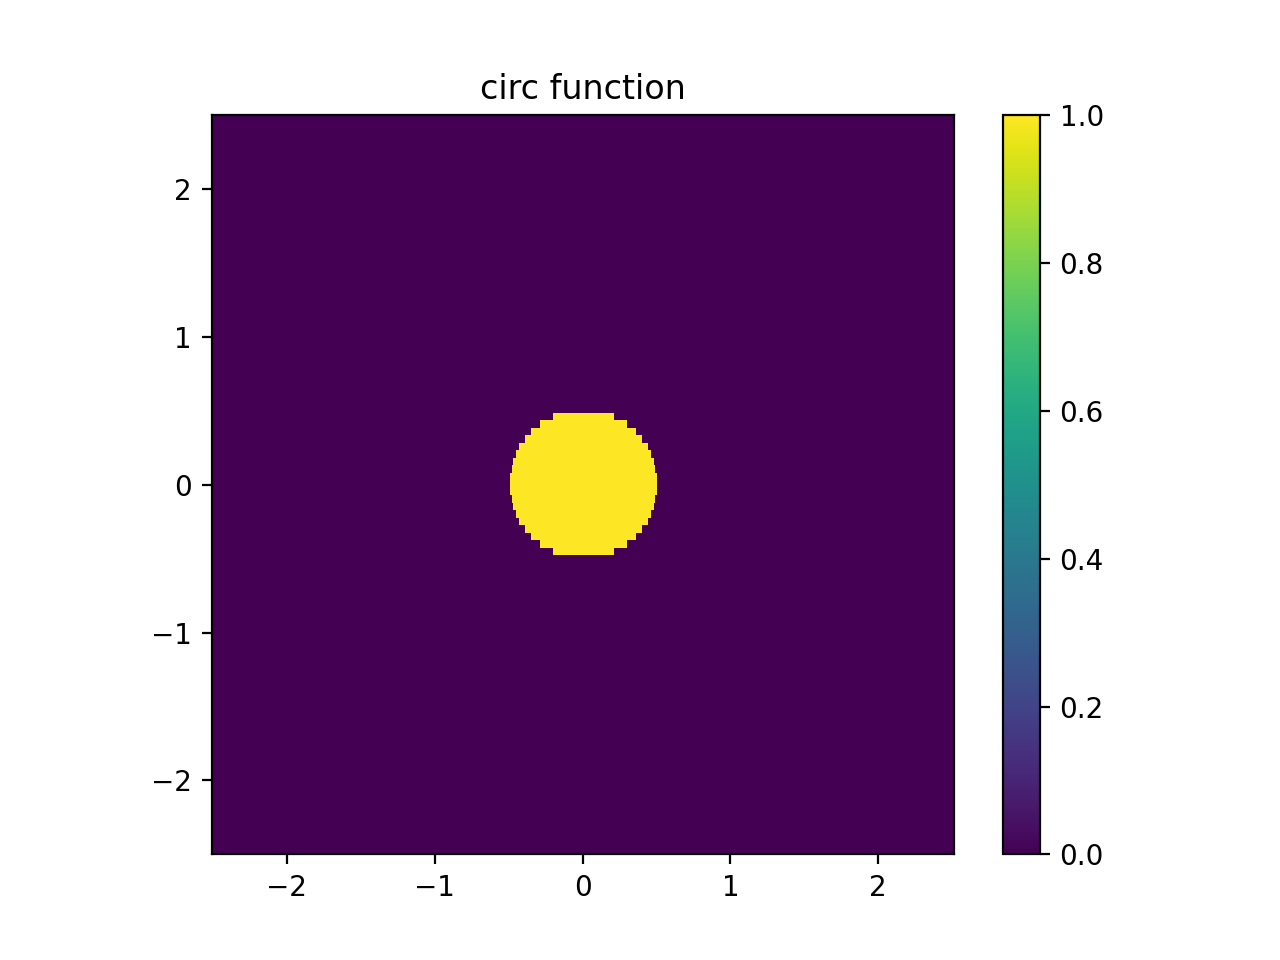

In [31]:
fig, ax = plt.subplots()
im = grid.imshow(ax, y)
fig.colorbar(im)
ax.set_title('circ function');

In [32]:
Omega_grid, y_Omega = grid.spectrum(y)

<IPython.core.display.Javascript object>


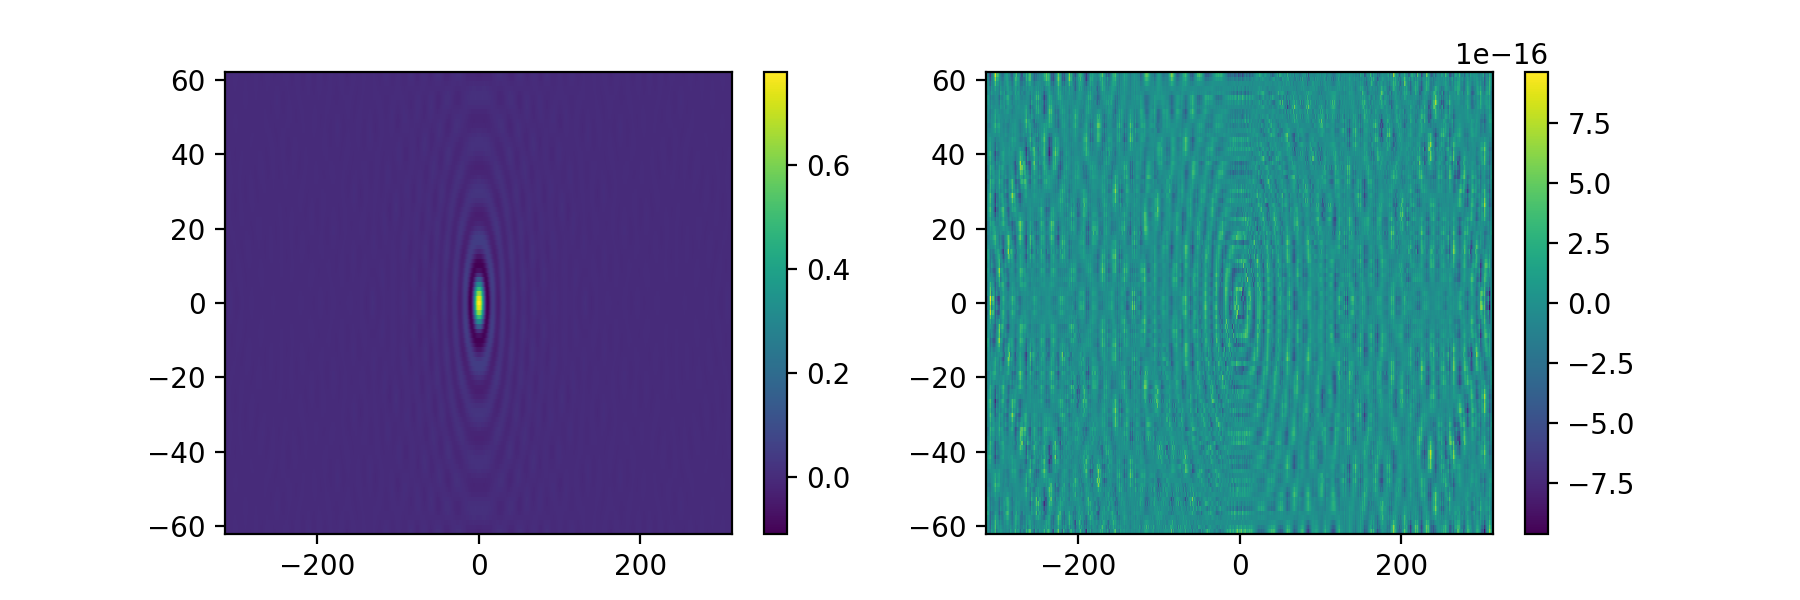

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 3))
im = Omega_grid.imshow(ax[0], np.real(y_Omega), aspect='auto')
fig.colorbar(im, ax=ax[0])
im = Omega_grid.imshow(ax[1], np.imag(y_Omega), aspect='auto')
fig.colorbar(im, ax=ax[1])

In [34]:
n0=(y_axis.x0/y_axis.T, x_axis.x0/x_axis.T)
n0

(-49.0, -250.0)

In [35]:
grid_dtft2, y_dtft2 = dtft2(y, n0=n0)

In [36]:
np.linalg.norm(np.real(y_dtft2)), np.linalg.norm(np.imag(y_dtft2))

(8731.189094275762, 3.9267575462540153e-11)

<IPython.core.display.Javascript object>


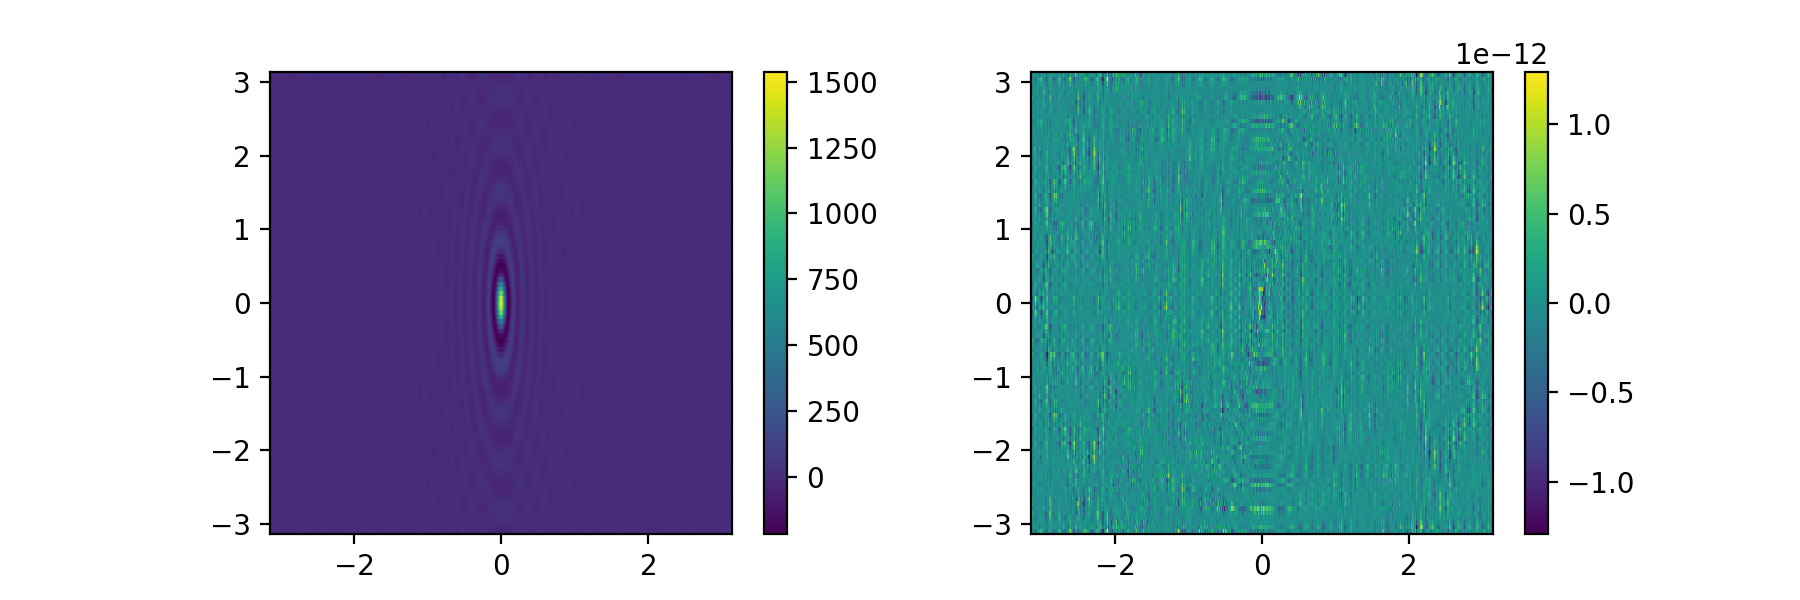

In [37]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 3))
im = grid_dtft2.imshow(ax[0], np.real(y_dtft2))
fig.colorbar(im, ax=ax[0])
im = grid_dtft2.imshow(ax[1], np.imag(y_dtft2))
fig.colorbar(im, ax=ax[1]);

In [38]:
y2_theory = besinc(np.sqrt((Omega_grid.centers[0]/(2*np.pi))**2 + (Omega_grid.centers[1]/(2*np.pi))**2))

<IPython.core.display.Javascript object>


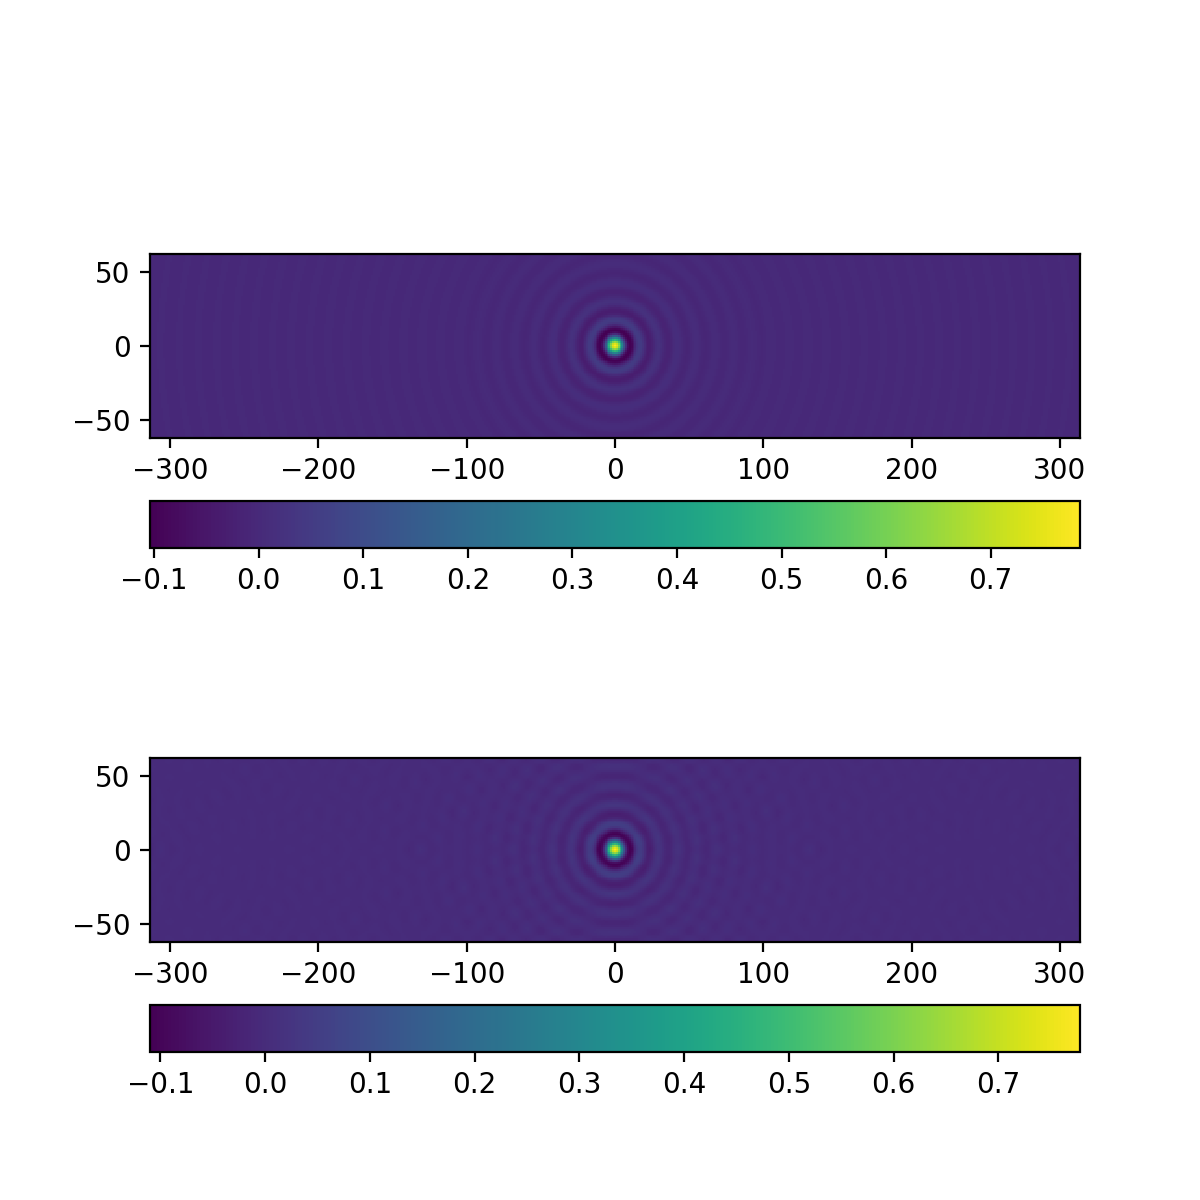

In [39]:
fig, ax = plt.subplots(nrows=2, figsize=(6, 6))
im = Omega_grid.imshow(ax[0], y2_theory)
fig.colorbar(im, ax=ax[0], orientation='horizontal')
im = Omega_grid.imshow(ax[1], np.real(y_Omega))
fig.colorbar(im, ax=ax[1], orientation='horizontal')

In [40]:
grid.spectrum_grid(real=True, s=(1024, 1024))

RegularGrid(axis_x=RFFTRegularAxis(x0=0, T=0.6123675799942679, N=513, _N_FULL=1024), axis_y=FFTRegularAxis(x0=-62.19718788925247, T=0.12147888259619623, N=1024))

In [41]:
Omega_grid2, y_Omega2 = grid.spectrum(y, real=True, s=(1024, 1024))

In [42]:
scipy.fft.rfft2(y).shape

(99, 251)

In [43]:
Omega_grid2, y_Omega2 = grid.spectrum(y, s=(1024, 1024))

<IPython.core.display.Javascript object>


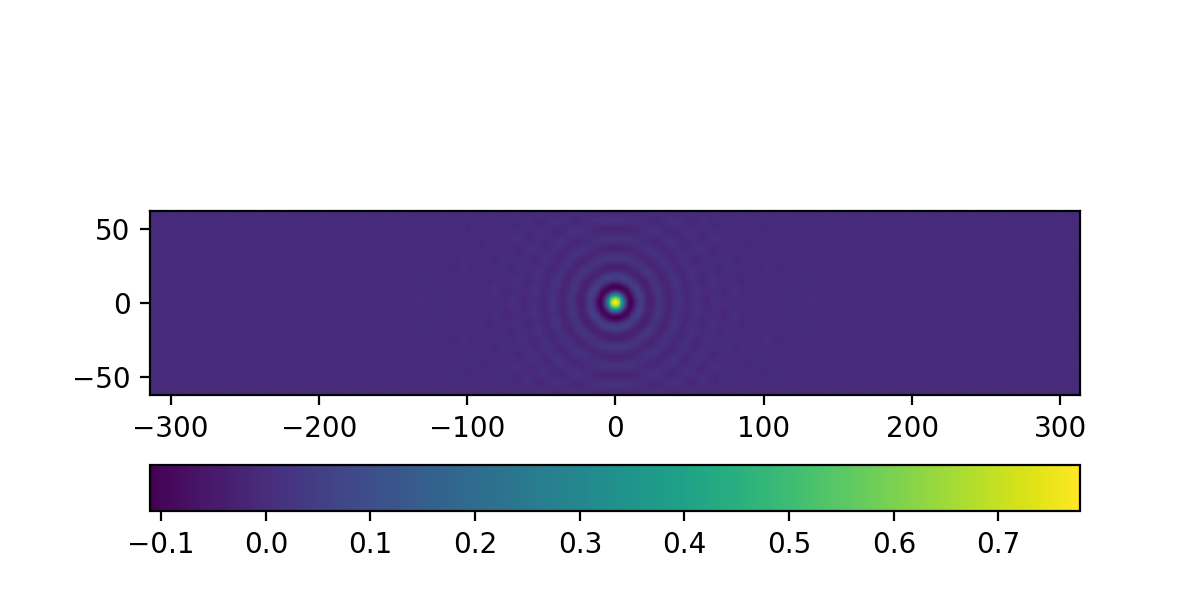

In [44]:
fig, ax = plt.subplots(figsize=(6, 3))
im = Omega_grid2.imshow(ax, np.real(y_Omega2))
fig.colorbar(im, ax=ax, orientation='horizontal')

# 

In [45]:
y_Omega2.shape

(1024, 1024)